In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# сгенерирум вот такие простые игрушечные данные
X = np.array([
    [3,2],
    [2, 2.5],
    [5,1],
    [4,3],
    [1,1],
    [1, -1],
    [3, -1],
    [2.5, 0.5]
])
y = np.array([1, 1,1,1,-1,-1,-1,-1])

In [2]:
# начинаем писать класс СВМ
# вот наша функция минимизации L = 0.5 * ||w||^2 - C * ∑ max(0, 1 - y(i)(wx(i) + b))
# коэффициент С - гиперпараметр, который подбирается с помощью валидации. Чем он больше, тем сильнее штраф за неправильную
# классификацию. Пока будет использовать 0.1
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param = 0.1, num_iterations=5000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.num_iterations = num_iterations
        
        
    def fit(self, X, y, lambda_param):
        
        # Инициализируем веса w и смещение b
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features) # начинаем как всегда с рандомных значений весов
        self.b = 0
        
        for _ in range(self.num_iterations):
            for i, x_i in enumerate(X):
                condition = y[i] * (x_i @ self.w + self.b) >= 1 
                # если x_i @ self.w + self.b равняется отрицательноу значению, а класс -1, то минус на минус даст плюс.
                # то же самое в случае положительного класса. А значит если модель правильно определила класс, то это значение
                # должно быть больше или равно 1
                if condition:
                    self.w -= self.learning_rate * (self.lambda_param * self.w)
                    # в таком случае вторая часть функции потери равна 0
                else:
                    # а вот если произошла мисклассификация, то берем полные производные
                    self.w -= self.learning_rate * (self.lambda_param * self.w - (x_i* y[i]))
                    self.b -= self.learning_rate * self.lambda_param * -y[i]
                    
    def predict(self, X):
        # пишем функцию для предикта
        result = X @ self.w + self.b
        return np.sign(result) #np.sign вернет +1, если результат положительный и -1 в обратном случае. То, что нам и нужно
    
    def get_weights(self):
        # на всякий случай пишем функции возврата вектора w и смещения b
        return self.w
    
    def get_bias(self):
        return self.b
    
    def plot_hyperplane(self, X):
        # Определяем пределы графика по осям x и y
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001), np.arange(y_min, y_max, 0.001))
        grid = np.c_[xx.ravel(), yy.ravel()]
        
        # Вычисляем значения гиперплоскости на сетке точек
        Z = self.predict(grid)
        Z = Z.reshape(xx.shape)
        
        # Отображаем гиперплоскость и обучающие данные на графике
        plt.figure(figsize=(8,8),dpi=100)
        plt.contourf(xx, yy, Z, cmap='magma', alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y)
        plt.title("SVM")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()
        

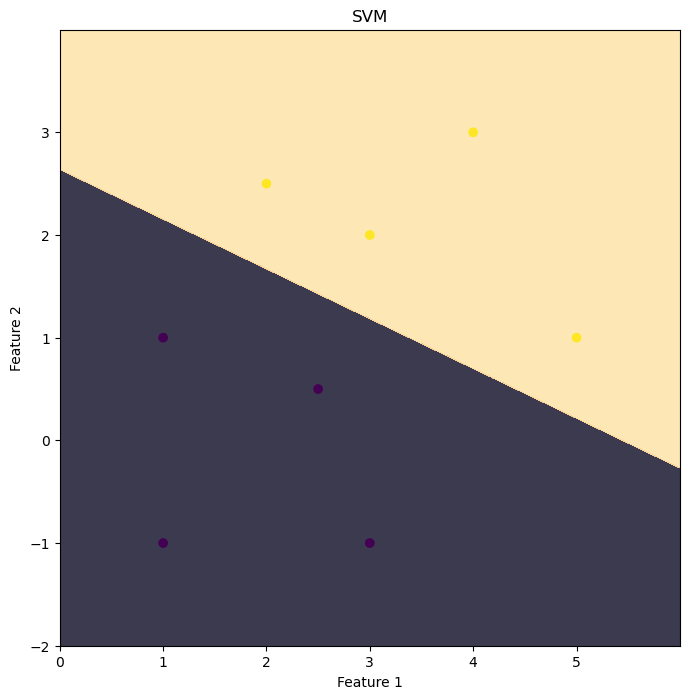

In [20]:
svm = SVM()
svm.fit(X, y, 0.1)
svm.plot_hyperplane(X)

Проверим работу нашей модели на случайных данных

In [21]:
N = 200
X1 = np.random.rand(N, 2) + [0.4, 0.3]
X2 = np.random.rand(N, 2) - [0.3, 0.4]
X = np.concatenate((X1, X2))
y = np.concatenate((np.ones(N), -np.ones(N)))

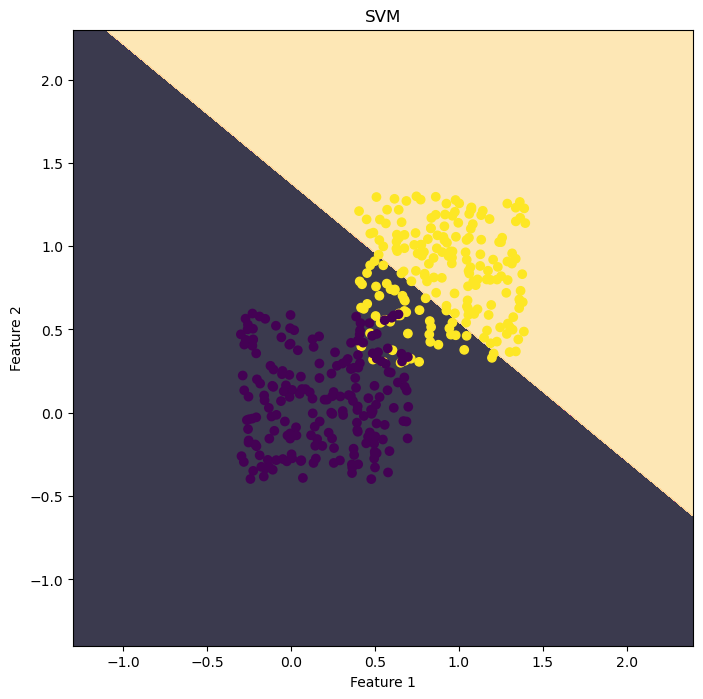

In [22]:
svm.fit(X, y, 0.1)
svm.plot_hyperplane(X)

Упс. Визуально заметно, что линия не там, где должна быть. Почему? Все дело в параметре регуляризации. Сейчас стоит слишком большое значение lambda_param. Штраф за мисклассификацию высокий. Попробуем уменьшить

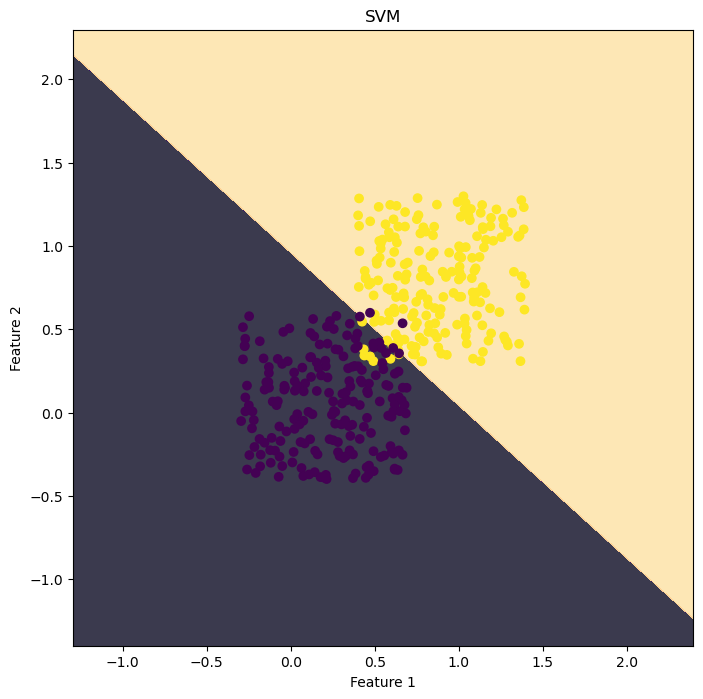

In [47]:
svm.fit(X, y, 0.005)
svm.plot_hyperplane(X)

Совсем другое дело.

А теперь проверим нашу модель на мейнстримной базе титаника. Не будем проводить муторную работу с заполнением данных, так как
это просто показательный пример.

In [26]:
import pandas as pd

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True) # переводим пол в нули и единицы

In [5]:
df = df[['Survived', 'Sex_male', 'Age', 'Pclass']] 
# я просто оставлю лишь 3 признака для предикта: пол, возраст и класс

In [6]:
df['Survived'] = df['Survived'].replace(0, -1)
# помним, что svc работает с 1 и -1

In [7]:
df = df.dropna()
# тупо избавляемся от пропусков

In [8]:
X = df.drop('Survived', axis=1).values
y= df['Survived'].values

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.2, random_state=15)

Поскольку мы работаем с векторами, желательно стандартизировать данные, чтобы привести их к единому масштабу.

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # на тестовой только трансформируем, дабы изжать "утечки" данных

In [16]:
svm.fit(X_train_scaled, y_train, 0.02) # параметр C выбрал на глаз

In [17]:
preds = svm.predict(X_test_scaled)

In [25]:
confusion_matrix(y_test, preds)

array([[70, 12],
       [15, 46]], dtype=int64)

In [18]:
accuracy_score(y_test, preds)

0.8111888111888111

Бам. 81% точности, используя всего лишь 3 признака и 571 тренировочный объект. Славный результат.